In [1]:
import deepchem as dc
import pandas as pd
import numpy as np
import csv

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:


def DatasetGenerator():
    #first we read the csv file to featurize oligomer 1:
    #descriptors to use are:
    descriptors = ["BCUT2D_CHGLO",
    "BCUT2D_MRLOW",
    "Chi0",
    "MaxAbsPartialCharge",
    "NumHAcceptors"
    ]

    with open('./csv_files/OURDATASET2.csv','r') as file:
        reader = csv.reader(file, delimiter = ',')
        X = []
        y = []
        Ids = []
        #define out featurizer with the 5 descriptors
        featurizer = dc.feat.RDKitDescriptors(descriptors=descriptors)
        for idx, row in enumerate(reader):
            if row[0] != "Oligomer1":  #skip the first header row
                frac =  float(row[2])
                
                #calculate descriptors for the oligomers
                feat1 = featurizer.featurize(row[0])
                feat2 = featurizer.featurize(row[1])

                """since these feats are only present for a fraction we multiply the feats of oligomer 1 with the according fraction it is present,
                the same will be done for oligomer 2"""
                
                feat1 = feat1 * frac
                feat2 = feat2 * (1-frac)

                #the feats are returned as np culumns so we ravel them
                feat1 = feat1.ravel()
                feat2 = feat2.ravel()
                X_row = np.append(feat1,feat2)

                #add the combined array
                X.append(X_row)

                #add the density
                y.append(float(row[3]))

                #now generate an ID of the mixture:
                id = row[0] + "|" + row[1] + "|" + row[2]
                Ids.append(id)
    X_data = np.nan_to_num(X, copy=True, nan=0.0)
    #both y and ids are rows but we need columns


    #add data to dataset
    Dataset = dc.data.DiskDataset.from_numpy(X=X_data, y=y, ids=Ids, tasks = ["Density"])

    return Dataset




In [3]:
#read the csv file
Dataset = DatasetGenerator()
print('loading the data...')

#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(Dataset)
print("Data is splitted into: train, valid, test")

# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct

kernel = 1 * RBF()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(test_dataset)


loading the data...
Data is splitted into: train, valid, test
fitting model...
model is fitted


In [4]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 0.9999999766425262}
Test set score: {'pearson_r2_score': 0.9999999702835469}


In [5]:
#calculate MSE score
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
print('Training set score:', model.evaluate(train_dataset, metric))
test_RMSE_score = model.evaluate(test_dataset, metric)
print('Test set score:', test_RMSE_score )

Training set score: {'mean_squared_error': 1.8322789858569298e-11}
Test set score: {'mean_squared_error': 2.35523929240066e-11}


In [6]:
#convert tekst to string, so it can be depicted in matplotlib
r2_number=list(test_score.values())[0]
rmse_number = list(test_RMSE_score.values())[0]
text = "r2= "+ str(round(r2_number,5)) + " & RMSE= "+ str(round(rmse_number,5))

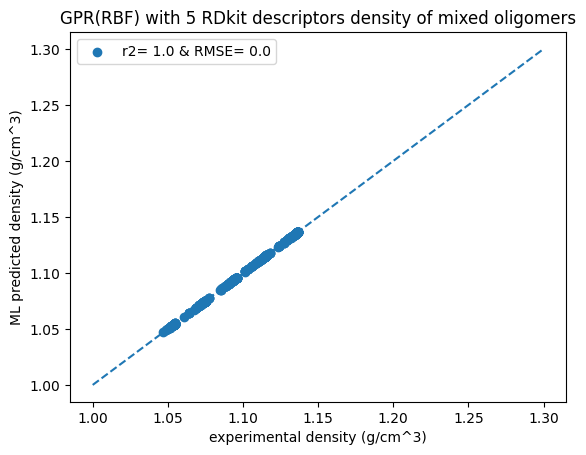

In [11]:
#plot the data
import matplotlib.pyplot as plt

x=[1,1.3]
y=[1,1.3]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label=text)
plt.legend()
plt.xlabel("experimental density (g/cm^3)")
plt.ylabel("ML predicted density (g/cm^3)")
plt.title("GPR(RBF) with 5 RDkit descriptors density of mixed oligomers")
plt.show()
